In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Combined Cleaned Dataset

In [2]:
import pandas as pd

file_path = "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Unnamed: 0,Label,clean_text,String,encoded_label
0,0,Non-bullying,kaka tidur yaa sudah pagi tidak boleh capek2,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",1.0
1,1,Non-bullying,makan nasi padang saja badannya,"""makan nasi padang aja begini badannya""",1.0
2,2,Bullying,suka cukur jembut manggung,"""yang aku suka dari dia adalah selalu cukur je...",0.0
3,3,Non-bullying,hai kak isyana ngefans sekali kak isyana suka ...,"""Hai kak Isyana aku ngefans banget sama kak Is...",1.0
4,4,Non-bullying,manusia bidadari sih herann deh cantik,"""Manusia apa bidadari sih herann deh cantik te...",1.0


# Tokenisasi dengan Spacy

In [3]:
import spacy

# Install spaCy multilingual model
!python -m spacy download xx_ent_wiki_sm

# Load spaCy multilingual model
nlp = spacy.load("xx_ent_wiki_sm")

# Tokenisasi menggunakan spaCy multibahasa
df['tokens'] = df['clean_text'].apply(
    lambda x: [token.text.lower() for token in nlp(x) if not token.is_punct and not token.is_space]
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 31.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
df.head()

,Unnamed: 0,Label,clean_text,String,encoded_label,tokens
0,0,Non-bullying,kaka tidur yaa sudah pagi tidak boleh capek2,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",1.0,"[kaka, tidur, yaa, sudah, pagi, tidak, boleh, ..."
1,1,Non-bullying,makan nasi padang saja badannya,"""makan nasi padang aja begini badannya""",1.0,"[makan, nasi, padang, saja, badannya]"
2,2,Bullying,suka cukur jembut manggung,"""yang aku suka dari dia adalah selalu cukur je...",0.0,"[suka, cukur, jembut, manggung]"
3,3,Non-bullying,hai kak isyana ngefans sekali kak isyana suka ...,"""Hai kak Isyana aku ngefans banget sama kak Is...",1.0,"[hai, kak, isyana, ngefans, sekali, kak, isyan..."
4,4,Non-bullying,manusia bidadari sih herann deh cantik,"""Manusia apa bidadari sih herann deh cantik te...",1.0,"[manusia, bidadari, sih, herann, deh, cantik]"


Import Library :

In [4]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset

# Create Vocabulary and Index Token

In [6]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = list(set(all_tokens))
word2idx = {word: idx+2 for idx, word in enumerate(vocab)}  # +2 untuk <PAD> dan <UNK>
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

def encode(tokens, word2idx, max_len=50):
    idxs = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    if len(idxs) < max_len:
        idxs += [word2idx['<PAD>']] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return idxs

df['input_ids'] = df['tokens'].apply(lambda x: encode(x, word2idx))


# Data Train, Test, Validation Split dan Buat Dataset dan DataLoader

In [7]:
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Dataset
X = df['input_ids'].tolist()
y = df['encoded_label'].tolist()

dataset = TextDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TextDataset(X_train, y_train)
test_data = TextDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)


# Model Bi-GRU

In [8]:
class BiGRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiGRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers,
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        _, hidden = self.gru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.fc(hidden)
        return output


# Evaluation and Training :

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiGRUModel(
    vocab_size=len(word2idx),
    embed_dim=100,
    hidden_dim=128,
    output_dim=2,  # dua kelas
    n_layers=2,
    dropout=0.3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        # Access the input_ids and label from the batch dictionary
        X_batch = batch['input_ids']
        y_batch = batch['label']

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        # Ensure the target tensor (y_batch) is of type Long for CrossEntropyLoss
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Assuming train_loader is defined elsewhere or you intended to use dataloader
    # If train_loader is not defined, replace it with dataloader
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 0.4882
Epoch 2, Loss: 0.3592
Epoch 3, Loss: 0.2573
Epoch 4, Loss: 0.1922
Epoch 5, Loss: 0.1383


# Evaluation Accuracy :

In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        # Access tensors using dictionary keys
        X_batch = batch['input_ids']
        y_batch = batch['label']

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Akurasi: {correct/total:.2f}")

Akurasi: 0.86



✅ Accuracy: 0.8575

📊 Confusion Matrix:
 [[207  12]
 [ 47 148]]

📋 Classification Report:
               precision    recall  f1-score   support

    Bullying       0.81      0.95      0.88       219
Non-Bullying       0.93      0.76      0.83       195

    accuracy                           0.86       414
   macro avg       0.87      0.85      0.85       414
weighted avg       0.87      0.86      0.86       414



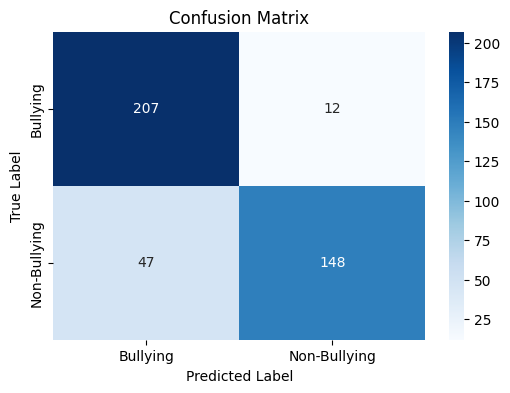

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['input_ids'].to(device)
        y_batch = batch['label'].to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ✅ Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Accuracy: {accuracy:.4f}")

# 📊 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\n📊 Confusion Matrix:\n", cm)

# 📋 Classification Report
class_names = ["Bullying", "Non-Bullying"]
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\n📋 Classification Report:\n", report)

# 🔥 Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['input_ids'].to(device)
        y_batch = batch['label'].to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ✅ Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Accuracy: {accuracy:.4f}")

# 📊 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\n📊 Confusion Matrix:\n", cm)

# 📋 Classification Report
report = classification_report(all_labels, all_preds, target_names=["Bullying", "Non-Bullying"])
print("\n📋 Classification Report:\n", report)



✅ Accuracy: 0.8575

📊 Confusion Matrix:
 [[207  12]
 [ 47 148]]

📋 Classification Report:
               precision    recall  f1-score   support

    Bullying       0.81      0.95      0.88       219
Non-Bullying       0.93      0.76      0.83       195

    accuracy                           0.86       414
   macro avg       0.87      0.85      0.85       414
weighted avg       0.87      0.86      0.86       414



In [13]:
!git clone https://github.com/WilliamAxelC/Indonesian-Cyberbullying-Detection-with-Distilbert.git

Cloning into 'Indonesian-Cyberbullying-Detection-with-Distilbert'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 89 (delta 41), reused 76 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 11.38 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import shutil, os

# Nama file notebook sesuai dengan yang kamu save di Drive
notebook_name = "Bi-GRU-Pytorch.ipynb"
src_path = f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}"
repo_dir = "/content/Indonesian-Cyberbullying-Detection-with-Distilbert"

if os.path.exists(src_path):
    shutil.copy(src_path, f"{repo_dir}/{notebook_name}")
    print(f"✅ Copied {notebook_name} ke repo folder.")
else:
    print(f"⚠️ Notebook tidak ditemukan di {src_path}. Periksa nama file!")


⚠️ Notebook tidak ditemukan di /content/drive/MyDrive/Colab Notebooks/Bi-GRU-Pytorch.ipynb. Periksa nama file!
